Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [5]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import seaborn as sns
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout,BatchNormalization
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [6]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive/')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive/


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [7]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/extracted_files/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/extracted_files/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [8]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [10]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [11]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

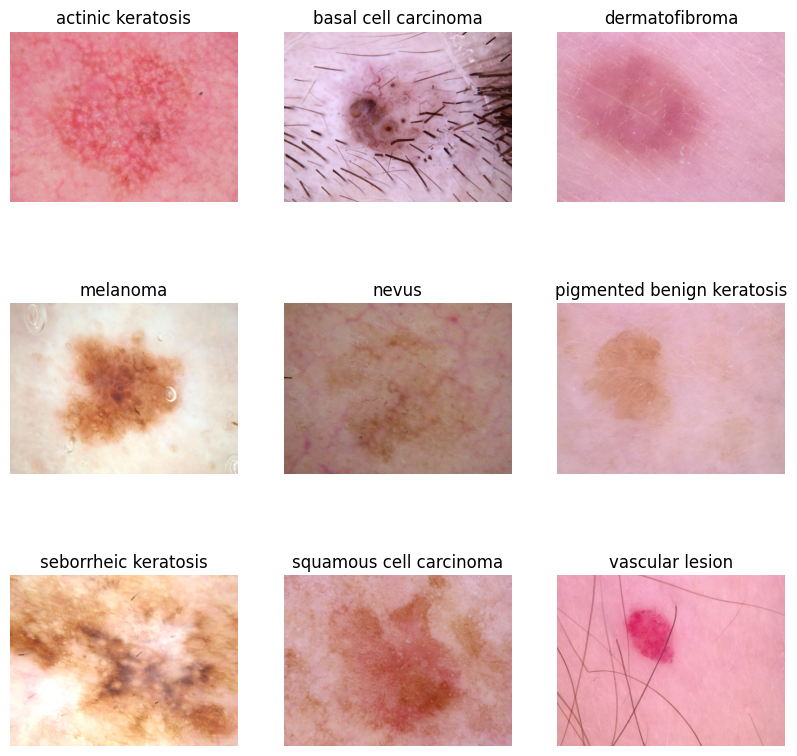

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  image = plt.imread(
      str(list(data_dir_train.glob(f'{class_names[i]}/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
  plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(16, kernel_size=(7, 7),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(11,11),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [16]:
### Todo, choose an appropirate optimiser and loss function
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 16)          │          50,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 5, 5, 128)           │         247,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 2, 2, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 720,601 (2.75 MB)

 Trainable params: 720,601 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [18]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 130ms/step - accuracy: 0.1704 - loss: 2.1001 - val_accuracy: 0.1924 - val_loss: 2.0778
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.2249 - loss: 2.0347 - val_accuracy: 0.2058 - val_loss: 2.0274
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.2044 - loss: 2.0212 - val_accuracy: 0.2058 - val_loss: 2.0207
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.2039 - loss: 2.0428 - val_accuracy: 0.2058 - val_loss: 2.0278
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.1786 - loss: 2.0395 - val_accuracy: 0.2058 - val_loss: 2.0267
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.1944 - loss: 2.0513 - val_accuracy: 0.2058 - val_loss: 2.0223
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.1997 - loss: 2.0240 - val_accuracy: 0.1924 - val_loss: 2.0297
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.1990 - loss: 2.0081 - val_accuracy: 0.2058 -

### Visualizing training results

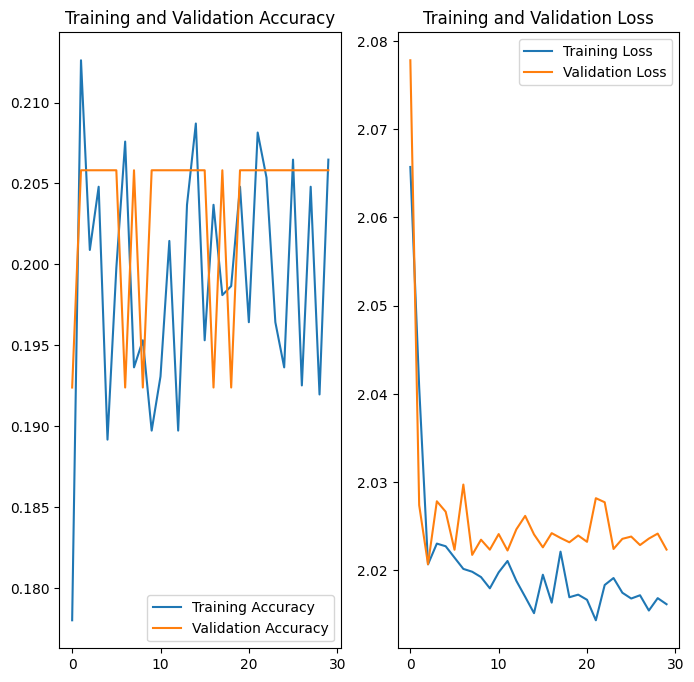

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
def model_accfortrainval(model):
    loss, accuracy = model.evaluate(train_ds, verbose=1,)
    loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

    print("Accuracy: ", accuracy)
    print("Validation Accuracy: ",accuracy_v)
    print("Loss: ",loss)
    print("Validation Loss", loss_v)

In [22]:
model_accfortrainval(model)

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2103 - loss: 2.0195
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2069 - loss: 1.9908
Accuracy:  0.2064732164144516
Validation Accuracy:  0.20581655204296112
Loss:  2.0142881870269775
Validation Loss 2.0223681926727295


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

**Observations:**

1. **Underfitting Indication**: Both training and validation accuracies are low and closely matched, suggesting that the model is underfitting. This means the model is too simple to capture the underlying patterns in the data.

2. **Training Loss vs. Validation Loss**: The training loss is low, indicating that the model performs well on the training data. However, the fluctuating validation loss suggests that the model struggles to generalize to unseen data, possibly due to overfitting on certain epochs or instability in the training process.

3. **Model Complexity**: The combination of low accuracy and fluctuating validation loss implies that the model might need more complexity (e.g., additional layers, more neurons, or different architectures) or better regularization techniques to improve its performance and stability.

In [23]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
augmentation_data = keras.Sequential([
                                      layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
                                      layers.RandomRotation(0.3),
                                      layers.RandomZoom(0.1),
                                      layers.RandomContrast(0.1),
])

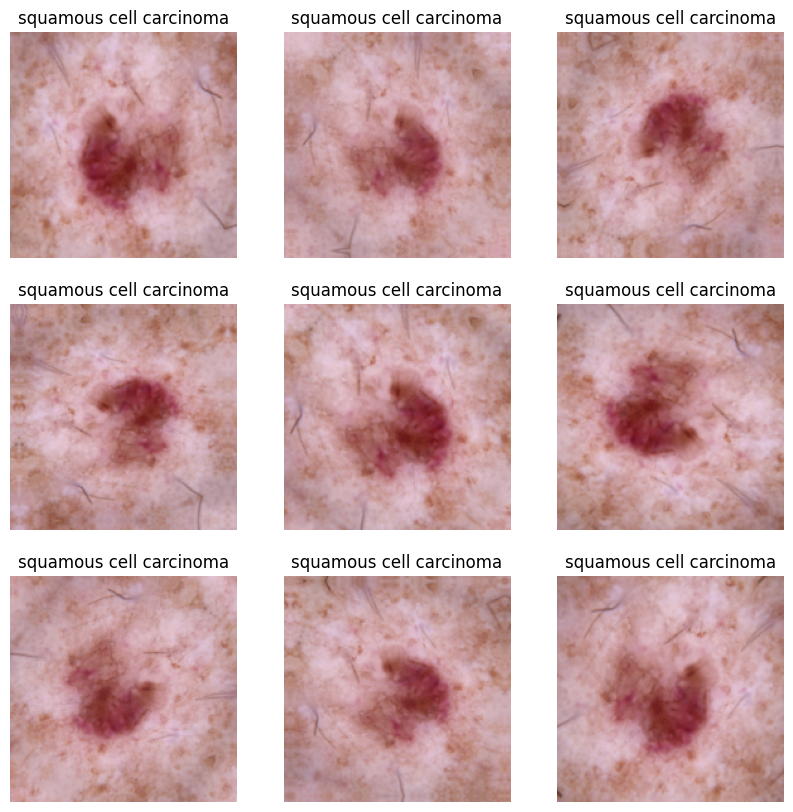

In [24]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [25]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model_2 = Sequential()

model_2.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model_2.add(augmentation_data)
model_2.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model_2.add(MaxPool2D(pool_size = (2, 2)))
model_2.add(Dropout(0.25))
model_2.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model_2.add(MaxPool2D(pool_size = (2, 2)))
model_2.add(Dropout(0.25))
model_2.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model_2.add(MaxPool2D(pool_size = (2, 2)))
model_2.add(Dropout(0.25))
model_2.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model_2.add(MaxPool2D(pool_size = (2, 2)))
model_2.add(Conv2D(16, kernel_size=(7, 7),padding = 'Same',activation= 'relu'))
model_2.add(MaxPool2D(pool_size = (2, 2)))
model_2.add(Dropout(0.25))
model_2.add(Conv2D(128, kernel_size=(11, 11),padding = 'Same',activation ='relu'))
model_2.add(MaxPool2D(pool_size = (2, 2)))
model_2.add(Dropout(0.25))
model_2.add(Conv2D(256, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model_2.add(MaxPool2D(pool_size = (2, 2)))
model_2.add(Dropout(0.25))
model_2.add(Flatten())
model_2.add(Dense(128,activation='relu'))
model_2.add(Dense(9,activation='softmax'))

### Compiling the model

In [26]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model_2.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [27]:
# View the summary of all layers
model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 45, 45, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 22, 22, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 11, 11, 16)          │          50,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 5, 5, 128)           │         247,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 2, 2, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 720,601 (2.75 MB)

 Trainable params: 720,601 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [28]:
## Your code goes here, note: train your model for 20 epochs
%%time
history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.1926 - loss: 2.1382 - val_accuracy: 0.2058 - val_loss: 2.0707
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.1924 - loss: 2.0376 - val_accuracy: 0.1924 - val_loss: 2.0078
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.2232 - loss: 1.9852 - val_accuracy: 0.3154 - val_loss: 1.8464
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.2550 - loss: 1.9684 - val_accuracy: 0.1924 - val_loss: 2.0301
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.2171 - loss: 2.0084 - val_accuracy: 0.2215 - val_loss: 2.0388
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.2485 - loss: 1.9882 - val_accuracy: 0.2685 - val_loss: 1.8645
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.2976 - loss: 1.8219 - val_accuracy: 0.3378 - val_loss: 1.7700
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.3491 - loss: 1.7549 - val_accuracy: 0.3960 - 

### Visualizing the results

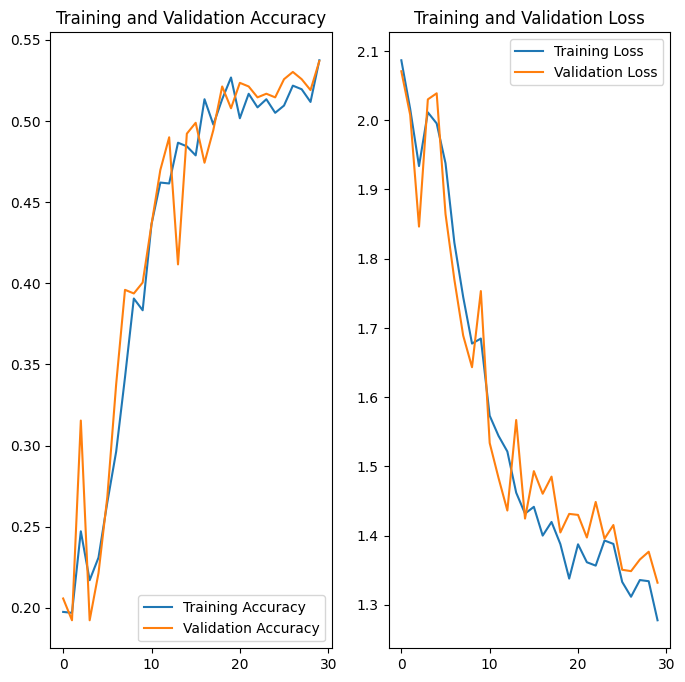

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
model_accfortrainval(model_2)

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5529 - loss: 1.2368
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5613 - loss: 1.2702
Accuracy:  0.5524553656578064
Validation Accuracy:  0.536912739276886
Loss:  1.2448861598968506
Validation Loss 1.3321205377578735


**Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?**

**observations:**

1. **Close Accuracy and Loss Values**: The training and validation accuracies, as well as their losses, are relatively close. This suggests that the model is not overfitting but is also not performing well on either the training or validation data.

2. **Low Accuracy**: Both training and validation accuracies are low, indicating that the model is underfitting. This means it is not learning the underlying patterns in the data effectively.

3. **Need for More Training and Class Imbalance Handling**: The model likely requires more epochs to train properly. Additionally, addressing class imbalance in the dataset could help improve the model's performance by ensuring it learns equally from all classes.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [31]:
## find the image path for all class labels (lesions)
images_path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

## Extract the class labels (lesions)
lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesions_list))

2239


In [32]:
# Extract image path and class label in a dictionary
image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5])

[('/content/extracted_files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0027672.jpg', 'vascular lesion'), ('/content/extracted_files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0026467.jpg', 'vascular lesion'), ('/content/extracted_files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0031217.jpg', 'vascular lesion'), ('/content/extracted_files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0033254.jpg', 'vascular lesion'), ('/content/extracted_files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0033031.jpg', 'vascular lesion')]


In [33]:
# View the image path and class label in a df
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_df.head()

,Image Path,Label
0,/content/extracted_files/Skin cancer ISIC The ...,vascular lesion
1,/content/extracted_files/Skin cancer ISIC The ...,vascular lesion
2,/content/extracted_files/Skin cancer ISIC The ...,vascular lesion
3,/content/extracted_files/Skin cancer ISIC The ...,vascular lesion
4,/content/extracted_files/Skin cancer ISIC The ...,vascular lesion


In [34]:
## Inspecting the distribution of classes in the data
lesions_df[['Label']].value_counts()

,count
Label,
pigmented benign keratosis,462
melanoma,438
basal cell carcinoma,376
nevus,357
squamous cell carcinoma,181
vascular lesion,139
actinic keratosis,114
dermatofibroma,95
seborrheic keratosis,77


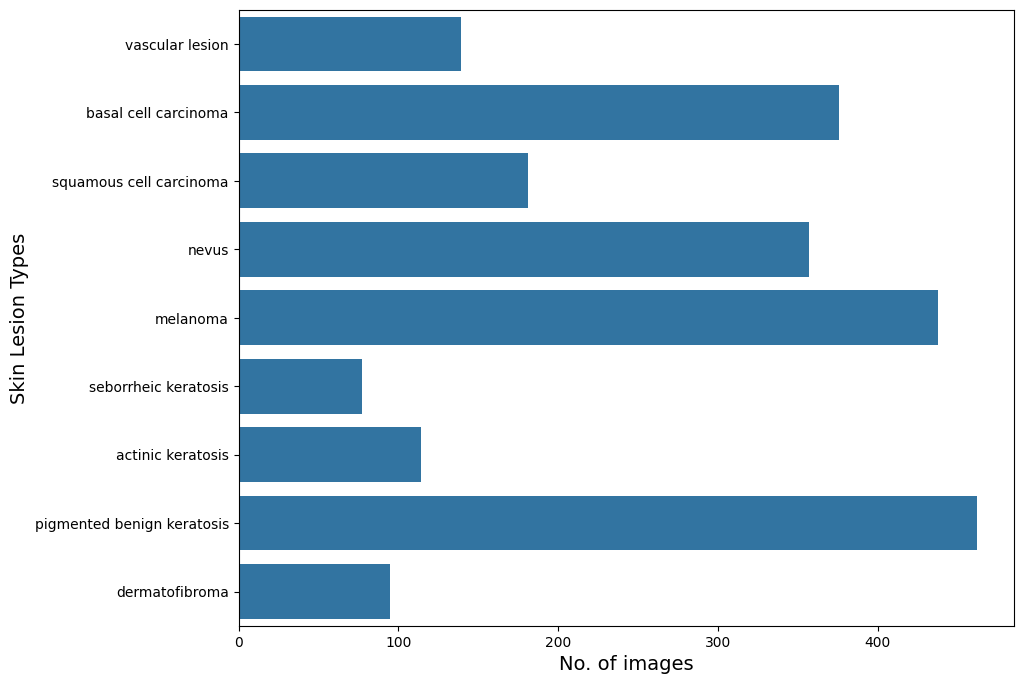

In [35]:
# Visualize the distribution of classes using a countplot
plt.figure(figsize=(10, 8))
sns.countplot(y="Label", data=lesions_df)
plt.xlabel('No. of images', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
**seborrheic keratosis**: The class with the least number of samples is **seborrheic keratosis**, with 77 samples.


#### - Which classes dominate the data in terms proportionate number of samples?
**pigmented benign keratosis** and **melanoma**: The classes that dominate the data in terms of the proportionate number of samples are **pigmented benign keratosis** with 462 samples and **melanoma** with 438 samples. These classes have the highest counts, indicating they are the most represented in the dataset.

The training data clearly shows a significant class imbalance.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [36]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline's` `sample()` method.


In [37]:
path_to_training_dataset="/content/extracted_files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/" # Add a forward slash at the end
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i) # Now the path is correctly formed
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.


Initialised with 114 image(s) found.
Output directory set to /content/extracted_files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D7698C06DA0>: 100%|██████████| 500/500 [00:21<00:00, 22.93 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/extracted_files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D77204F4370>: 100%|██████████| 500/500 [00:22<00:00, 21.95 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/extracted_files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D76EFF73190>: 100%|██████████| 500/500 [00:20<00:00, 24.32 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/extracted_files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D77200E1810>: 100%|██████████| 500/500 [01:32<00:00,  5.41 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/extracted_files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7D7713FB0070>: 100%|██████████| 500/500 [01:18<00:00,  6.35 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/extracted_files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D76EFFFE620>: 100%|██████████| 500/500 [00:17<00:00, 27.79 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/extracted_files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7D7698DA3700>: 100%|██████████| 500/500 [00:38<00:00, 12.96 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/extracted_files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D7713F76320>: 100%|██████████| 500/500 [00:15<00:00, 31.57 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/extracted_files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D76CE598A00>: 100%|██████████| 500/500 [00:15<00:00, 32.13 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [38]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [39]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/extracted_files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031955.jpg_17fa84ee-07b8-4861-b8b5-31f4bc301c79.jpg',
 '/content/extracted_files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027522.jpg_c7e86961-2b7e-4ddd-aaaa-eda8400447a5.jpg',
 '/content/extracted_files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024669.jpg_ff8ba331-69af-4b5e-bde5-5da2b86abe86.jpg',
 '/content/extracted_files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029608.jpg_0beac539-a8a2-48cc-a5de-cb281114ba7e.jpg',
 '/content/extracted_files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026713.jpg_7c8b707b-e3a5-46f4-9371-78ad

In [40]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [41]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [42]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Image Path','Label'])
# Use pd.concat instead of append to combine the two DataFrames
new_df = pd.concat([lesions_df, df2])
new_df.shape

(6739, 2)

In [43]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [44]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [47]:
data_dir_train="/content/extracted_files/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [48]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [49]:
model_3 = Sequential([
  layers.Rescaling(1.0/255),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(128, (3, 3), padding='same', activation=tf.nn.relu),
  BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(256, (3, 3), padding='same', activation=tf.nn.relu),
  BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dropout(0.25),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dropout(0.25),
  layers.Dense(64, activation=tf.nn.relu),
  layers.Dropout(0.25),
  layers.Dense(len(class_names),activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [50]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model_3.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [51]:
epochs = 50
history = model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 230ms/step - accuracy: 0.1828 - loss: 3.8831 - val_accuracy: 0.1581 - val_loss: 2.3178 - learning_rate: 0.0010
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 206ms/step - accuracy: 0.2487 - loss: 1.9786 - val_accuracy: 0.1507 - val_loss: 2.5771 - learning_rate: 0.0010
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 170ms/step - accuracy: 0.3079 - loss: 1.8136 - val_accuracy: 0.2480 - val_loss: 2.0266 - learning_rate: 0.0010
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 151ms/step - accuracy: 0.3356 - loss: 1.7043 - val_accuracy: 0.1641 - val_loss: 9.0080 - learning_rate: 0.0010
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 27s 157ms/step - accuracy: 0.3846 - loss: 1.6135 - val_accuracy: 0.2606 - val_loss: 2.7156 - learning_rate: 0.0010
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 153ms/step - accuracy: 0.3664 - loss: 1.6008 - val_accuracy: 0.4009 - val_loss: 1.6993 - learning_rate: 0.0010
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 152ms/step - accuracy: 0.4

#### **Todo:**  Visualize the model results

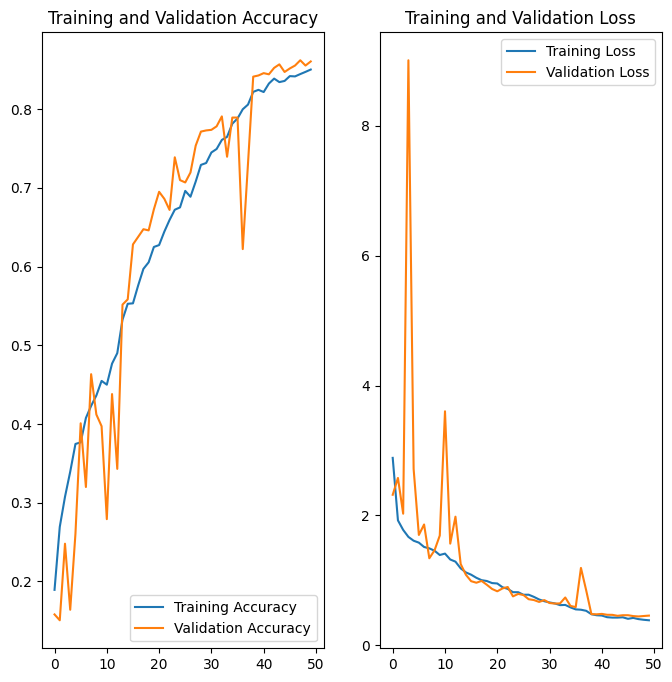

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [53]:
model_accfortrainval(model_3)

169/169 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - accuracy: 0.9260 - loss: 0.1998
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.8694 - loss: 0.4738 
Accuracy:  0.9276705980300903
Validation Accuracy:  0.8604305982589722
Loss:  0.198784738779068
Validation Loss 0.45742321014404297


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



**Observations:**

1. **Good Fit Indicated by Accuracy**: The training accuracy and validation accuracy being close suggests that the model is well-fitted to the data. This means it generalizes well to new, unseen data without overfitting.

2. **Consistent Loss Values**: The training loss and validation loss being close also indicates a good fit. This consistency means the model's performance is stable across both the training and validation datasets.

3. **High Validation Accuracy**: A validation accuracy of 0.86 (or 86%) is quite good. It shows that the model is able to classify the images correctly 86% of the time, indicating strong performance.